# Github management (Don't run unless required)

In [ ]:
from google.colab import userdata
token = userdata.get("GITHUB_TOKEN")

%cd /content/drive/MyDrive/Fraud Detection project files/

/content/drive/MyDrive/Fraud Detection project files


In [ ]:
# !git clone https://{token}@github.com/eigen-spaced/fraud-detection
# !mkdir ./fraud-detection/notebooks

fatal: destination path 'fraud-detection' already exists and is not an empty directory.
mkdir: cannot create directory ‘./fraud-detection/notebooks’: File exists


In [ ]:
!git config --global user.email {userdata.get("GIT_EMAIL")}
!git config --global user.name {userdata.get("GIT_USERNAME")}

In [ ]:
!cp ./xgboost_classification.ipynb ./fraud-detection/notebooks/
%cd fraud-detection
!git remote set-url origin https://{token}@github.com/eigen-spaced/fraud-detection.git
!git rm --cached notebooks/xgboost_classification.ipynb
!git add notebooks/xgboost_classification.ipynb
!git commit -m "Modify XGBoost model saving code"

/content/drive/MyDrive/Fraud Detection project files/fraud-detection
[main 7e291bd] Modify XGBoost model saving code


In [ ]:
!git push origin main

Enumerating objects: 14, done.
Counting objects: 100% (14/14), done.
Delta compression using up to 2 threads
Compressing objects: 100% (10/10), done.
Writing objects: 100% (10/10), 3.70 KiB | 37.00 KiB/s, done.
Total 10 (delta 5), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (5/5), completed with 3 local objects.
To https://github.com/eigen-spaced/fraud-detection.git
   57d2021..7e291bd  main -> main


In [ ]:
%cd ../

/content/drive/MyDrive/Fraud Detection project files


# Fraud detection analysis

This notebook is a part of my fraud intepretaibility application.
The data was generated using [https://github.com/namebrandon/Sparkov_Data_Generation](https://github.com/namebrandon/Sparkov_Data_Generation)

Our model is an XGBoost model.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score,
    classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    average_precision_score,
    precision_recall_curve,
    f1_score, precision_score, recall_score

)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

# Mount files from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

# Define the path to the directory containing the CSV files
# Replace 'your_folder_name' with the actual name of your folder
directory_path = '/content/drive/MyDrive/Fraud Detection project files/cc data'

# List all files and directories in the specified path
files_and_directories = os.listdir(directory_path)

# Filter out 'customers.csv'
csv_files = [f for f in files_and_directories if f.endswith('.csv') and f != 'customers.csv']

## Load and concatenate data

Read each CSV file into a pandas DataFrame and concatenate them into a single DataFrame.


In [4]:
# Create an empty list to store dataframes
dfs = []

# Iterate over the list of CSV files
for file in csv_files:
    # Construct the full file path
    file_path = os.path.join(directory_path, file)

    try:
        # Read the CSV file into a dataframe with the correct separator
        df = pd.read_csv(file_path, sep='|')

        # Append the dataframe to the list
        dfs.append(df)
    except Exception as e:
        print(f"Error reading file: {file_path}")
        print(f"Error details: {e}")


# Concatenate all dataframes in the list
combined_df = pd.concat(dfs, ignore_index=True)

/tmp/ipython-input-527636467.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(dfs, ignore_index=True)


In [5]:
print(f"Number of rows in the combined DataFrame: {combined_df.shape[0]}")

Number of rows in the combined DataFrame: 4473175


In [6]:
combined_df.head()

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,582-05-2984,3593917251355212,Roberto,Santiago,M,0433 Michael Turnpike Apt. 006,Tumacacori,AZ,85640,31.6162,...,0e24d2a5029472f7897ba5562f5229f7,2025-02-05,00:58:58,1738702738,gas_transport,22.91,1,fraud_Schmitt Inc,30.981676,-110.568793
1,582-05-2984,3593917251355212,Roberto,Santiago,M,0433 Michael Turnpike Apt. 006,Tumacacori,AZ,85640,31.6162,...,2cf609ab773bad11f0f0e462a4df1603,2025-02-05,02:56:06,1738709766,grocery_net,22.65,1,fraud_Morar Inc,31.175138,-110.907380
2,582-05-2984,3593917251355212,Roberto,Santiago,M,0433 Michael Turnpike Apt. 006,Tumacacori,AZ,85640,31.6162,...,6f1d102e0e7a46043ad6d0c6fbb91eb2,2025-02-05,02:58:19,1738709899,grocery_pos,14.69,1,"fraud_Rowe, Batz and Goodwin",32.397176,-111.198459
3,582-05-2984,3593917251355212,Roberto,Santiago,M,0433 Michael Turnpike Apt. 006,Tumacacori,AZ,85640,31.6162,...,3c4aec3cf8794a7303ef633dbb219f73,2025-02-05,00:43:00,1738701780,grocery_net,14.41,1,"fraud_Towne, Walker and Borer",31.372865,-110.970436
4,582-05-2984,3593917251355212,Roberto,Santiago,M,0433 Michael Turnpike Apt. 006,Tumacacori,AZ,85640,31.6162,...,2483806d18bd22dc1100eac626543adc,2025-02-05,05:00:18,1738717218,grocery_pos,332.93,1,"fraud_Goldner, Kovacek and Abbott",32.124765,-111.303317


## Basic data exploration and cleaning

Even though the data is not real, its best to remove any PII as well as columns that we won't be needing.

In [7]:
columns_to_drop = ["ssn", "first", "last", "unix_time", "gender", "street", "city", "state", "zip", "lat", "long", "city_pop", "job", "dob", "profile"]
modified_df = combined_df.drop(columns=columns_to_drop)

In [8]:
display(modified_df.head())

,cc_num,acct_num,trans_num,trans_date,trans_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,3593917251355212,462707927107,0e24d2a5029472f7897ba5562f5229f7,2025-02-05,00:58:58,gas_transport,22.91,1,fraud_Schmitt Inc,30.981676,-110.568793
1,3593917251355212,462707927107,2cf609ab773bad11f0f0e462a4df1603,2025-02-05,02:56:06,grocery_net,22.65,1,fraud_Morar Inc,31.175138,-110.907380
2,3593917251355212,462707927107,6f1d102e0e7a46043ad6d0c6fbb91eb2,2025-02-05,02:58:19,grocery_pos,14.69,1,"fraud_Rowe, Batz and Goodwin",32.397176,-111.198459
3,3593917251355212,462707927107,3c4aec3cf8794a7303ef633dbb219f73,2025-02-05,00:43:00,grocery_net,14.41,1,"fraud_Towne, Walker and Borer",31.372865,-110.970436
4,3593917251355212,462707927107,2483806d18bd22dc1100eac626543adc,2025-02-05,05:00:18,grocery_pos,332.93,1,"fraud_Goldner, Kovacek and Abbott",32.124765,-111.303317


## Remove rows with missing values and check data split for fraud vs non-fraud cases


Drop rows with missing values from the `modified_df` DataFrame and print the number of remaining rows.
Then we count the occurrences of each value in the `is_fraud` column to understand the distribution of fraudulent and non-fraudulent transactions and print the counts.



In [9]:
# Drop rows with missing values
modified_df = modified_df.dropna()
print(f"Number of rows after dropping missing values: {modified_df.shape[0]}\n")

# Count the occurrences of each value in the 'is_fraud' column
fraud_counts = modified_df['is_fraud'].value_counts()
print(fraud_counts)

Number of rows after dropping missing values: 4473175

is_fraud
0    4454114
1      19061
Name: count, dtype: int64


## Plot the binary split
Create a bar chart to visualize the distribution of fraudulent and non-fraudulent transactions using seaborn.

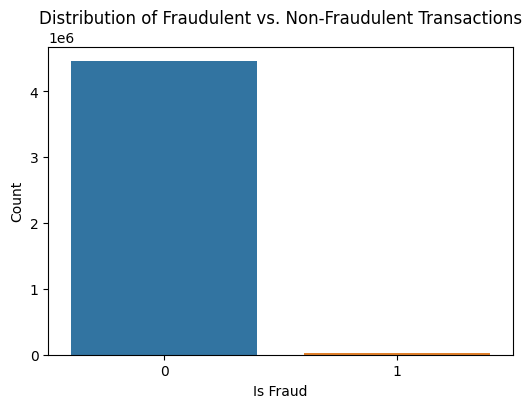

In [10]:
# Create a bar plot of the fraud_counts Series
plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, hue=fraud_counts.index.astype(str))

# Label the x-axis and y-axis
plt.xlabel('Is Fraud')
plt.ylabel('Count')

# Add a title to the plot
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')

# Display the plot
plt.show()

## Summary:

### Data Analysis Key Findings

*   No change to number of rows fter removing rows with missing values (4,473,175 rows).
*   The `is_fraud` column shows a significant imbalance: 4,454,114 transactions are non-fraudulent (value 0) and 19,061 transactions are fraudulent (value 1).

### Insights or Next Steps

*   The dataset exhibits a strong class imbalance regarding fraudulent transactions, which might require specific techniques like oversampling or undersampling for downstream modeling tasks.
*   The visualization confirms the severe class imbalance, highlighting the need for evaluation metrics beyond simple accuracy if a classification model is to be built.


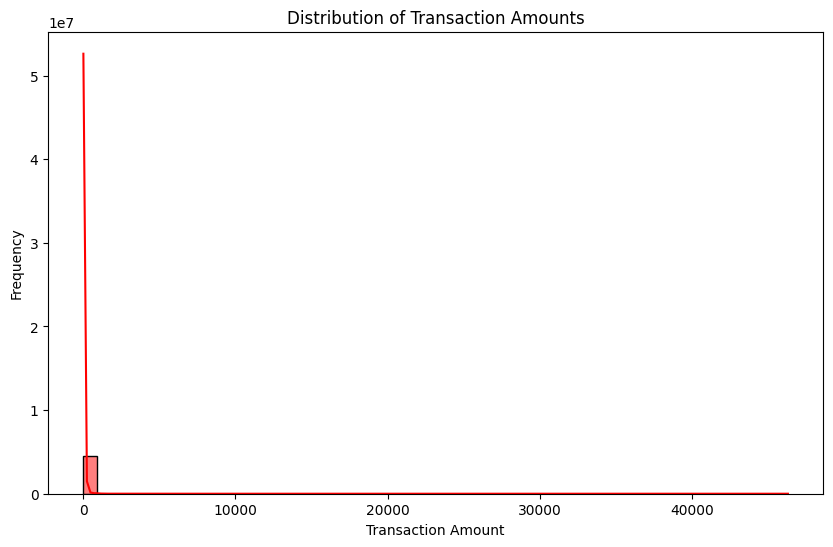

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(modified_df['amt'], kde=True, bins=50, color='r')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Amounts')
plt.show()

## Sort data and standardise dates

Sort the `modified_df` DataFrame by 'cc_num', 'trans_date', and 'trans_time' in ascending order.

ort the dataframe by 'cc_num', 'trans_date', and 'trans_time' to prepare for calculating time differences and distances between consecutive transactions for each credit card.

In [12]:
# Convert 'trans_date' and 'trans_time' to datetime objects
modified_df['trans_date'] = pd.to_datetime(modified_df['trans_date'])
modified_df['trans_time'] = pd.to_datetime(modified_df['trans_time'], format='%H:%M:%S').dt.time

# Combine date and time into a new 'trans_datetime' column
modified_df['trans_datetime'] = pd.to_datetime(modified_df['trans_date'].astype(str) + ' ' + modified_df['trans_time'].astype(str))

# Drop the original date and time columns as they are now redundant
modified_df = modified_df.drop(columns=['trans_date', 'trans_time'])

Now we sort by cc_num and trans_datetime for the best chance at series analysis

In [13]:
modified_df.sort_values(by=['cc_num', 'trans_datetime'], inplace=True)

Create a copy of our modified dataframe

In [14]:
# Ensure we operate on a copy of the existing DataFrame
feature_df = modified_df.copy()

Feature 1: Time Since Last Transaction (Cadence)

In [15]:
time_diff = feature_df.groupby('cc_num')['trans_datetime'].diff()
# Convert the Timedelta object to total seconds for the model
feature_df['time_since_last_trans_seconds'] = time_diff.dt.total_seconds()

Feature 2: Geospatial Velocity

In [16]:
def haversine_vec(lat1, lon1, lat2, lon2, R=6371.0):
    lat1_r = np.radians(lat1)
    lon1_r = np.radians(lon1)
    lat2_r = np.radians(lat2)
    lon2_r = np.radians(lon2)

    dlat = lat2_r - lat1_r
    dlon = lon2_r - lon1_r

    a = np.sin(dlat/2.0)**2 + np.cos(lat1_r) * np.cos(lat2_r) * np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Get previous coordinates (since data is sorted, this is guaranteed to be correct)
lat_prev = feature_df.groupby('cc_num')['merch_lat'].shift(1)
lon_prev = feature_df.groupby('cc_num')['merch_long'].shift(1)
lat_cur = feature_df['merch_lat']
lon_cur = feature_df['merch_long']

feature_df['distance_from_prev'] = haversine_vec(lat_prev, lon_prev, lat_cur, lon_cur) # in km

Feature 3: Transaction Speed (km/h)

In [17]:
# Avoid division by zero by adding a small epsilon to time_since_last_transaction_seconds
# Speed = Distance / Time (convert seconds to hours for km/h)
feature_df['trans_speed_kmh'] = (feature_df['distance_from_prev'] / (feature_df['time_since_last_trans_seconds'] / 3600 + 1e-6))
# Handle cases where distance is NaN (first transaction for a card) or speed becomes inf/nan
feature_df['trans_speed_kmh'] = feature_df['trans_speed_kmh'].replace([np.inf, -np.inf], np.nan)

Feature 4: Distance From Average Location (e.g., 7-day rolling average)

In [18]:
# Create a temporary DataFrame for rolling location calculations
temp_location_df = feature_df[['cc_num', 'trans_datetime', 'merch_lat', 'merch_long']].set_index('trans_datetime')

# Calculate rolling mean of latitude and longitude per card number over a 7-day window
# The min_periods=1 ensures that even for the first few transactions, an average is calculated
rolling_avg_loc = temp_location_df.groupby('cc_num').rolling('7d', min_periods=1)[['merch_lat', 'merch_long']].mean().reset_index()
rolling_avg_loc.rename(columns={'merch_lat': 'avg_lat_7d', 'merch_long': 'avg_long_7d'}, inplace=True)

# Merge these rolling averages back to the main DataFrame
feature_df = pd.merge(feature_df, rolling_avg_loc, on=['cc_num', 'trans_datetime'], how='left')

# Calculate distance from the current transaction location to the card's 7-day average location
feature_df['distance_from_avg_location_7d'] = haversine_vec(
    feature_df['merch_lat'], feature_df['merch_long'],
    feature_df['avg_lat_7d'], feature_df['avg_long_7d']
)
# Drop the temporary average lat/lon columns as they are no longer needed
feature_df = feature_df.drop(columns=['avg_lat_7d', 'avg_long_7d'])

Feature 5: Rolling Transaction Counts (Volume)

In [19]:
# This function is now applied to pre-sorted groups, which is efficient.
def add_time_window_counts(g):
    # Set index for time-based rolling
    g = g.set_index('trans_datetime')
    # Calculate rolling counts
    g['trans_in_last_1h']  = g['trans_num'].rolling('1h').count()
    g['trans_in_last_24h'] = g['trans_num'].rolling('24h').count()
    g['trans_in_last_7d']  = g['trans_num'].rolling('7d').count()
    # Reset index to bring trans_datetime back as a column
    g = g.reset_index()
    return g

# Apply the function to each card number group
feature_df = feature_df.groupby('cc_num', group_keys=False).apply(add_time_window_counts)


# Final Output
display(feature_df.head())

/tmp/ipython-input-3632311512.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_df = feature_df.groupby('cc_num', group_keys=False).apply(add_time_window_counts)


,trans_datetime,cc_num,acct_num,trans_num,category,amt,is_fraud,merchant,merch_lat,merch_long,time_since_last_trans_seconds,distance_from_prev,trans_speed_kmh,distance_from_avg_location_7d,trans_in_last_1h,trans_in_last_24h,trans_in_last_7d
0,2023-01-01 02:15:59,60400268763,279317935556,417473688cec715a2d4fc745a3267cc5,gas_transport,2.35,0,fraud_Mraz-Herzog,40.699828,-93.120762,NaN,NaN,NaN,0.000000,1.0,1.0,1.0
1,2023-01-01 02:24:55,60400268763,279317935556,79472dbb9cf569a748a0f7006a48f8c0,gas_transport,8.04,0,"fraud_Eichmann, Bogan and Rodriguez",41.968246,-92.851952,536.0,142.815970,959.205293,71.399483,2.0,2.0,2.0
2,2023-01-01 03:41:06,60400268763,279317935556,1367c01d358ac62facf92c1193bfd65a,gas_transport,71.50,0,fraud_Cummings LLC,40.577116,-93.014709,4571.0,155.283370,122.297023,56.133048,1.0,3.0,3.0
3,2023-01-01 04:22:17,60400268763,279317935556,4a050f70a34d8d9e8f018e718cc55a76,gas_transport,8.86,0,"fraud_Schaefer, McGlynn and Bosco",42.462321,-92.647985,2471.0,211.836321,308.623896,117.139888,2.0,4.0,4.0
4,2023-01-01 07:26:18,60400268763,279317935556,8e6e3632682c8ba66bfd8bced49003c4,gas_transport,116.26,0,fraud_Harris Inc,41.155424,-94.097921,11041.0,188.565907,61.483294,83.094105,1.0,5.0,5.0


## Sampling for Visualisation

In [20]:
# Get all fraud cases
fraud_df = feature_df[feature_df['is_fraud'] == 1].copy()

# Sample an equal number of legitimate cases (or slightly more, e.g., 5x)
# Ensure the sample size doesn't exceed available legitimate transactions
n_legit_sample = min(len(fraud_df) * 1, len(feature_df[feature_df['is_fraud'] == 0])) # 1:1 ratio for now, can be adjusted
legit_sample = feature_df[feature_df['is_fraud'] == 0].sample(n=n_legit_sample, random_state=42).copy()
# Combine for plotting
plot_df = pd.concat([fraud_df, legit_sample])

# It's good practice to handle NaNs for plotting, especially for new features like speed/distance
plot_df = plot_df.dropna(subset=[
    'time_since_last_trans_seconds',
    'distance_from_prev',
    'trans_speed_kmh',
    'distance_from_avg_location_7d',
    'trans_in_last_1h' # Include other features in droppna if they are critical and can be NaN
])

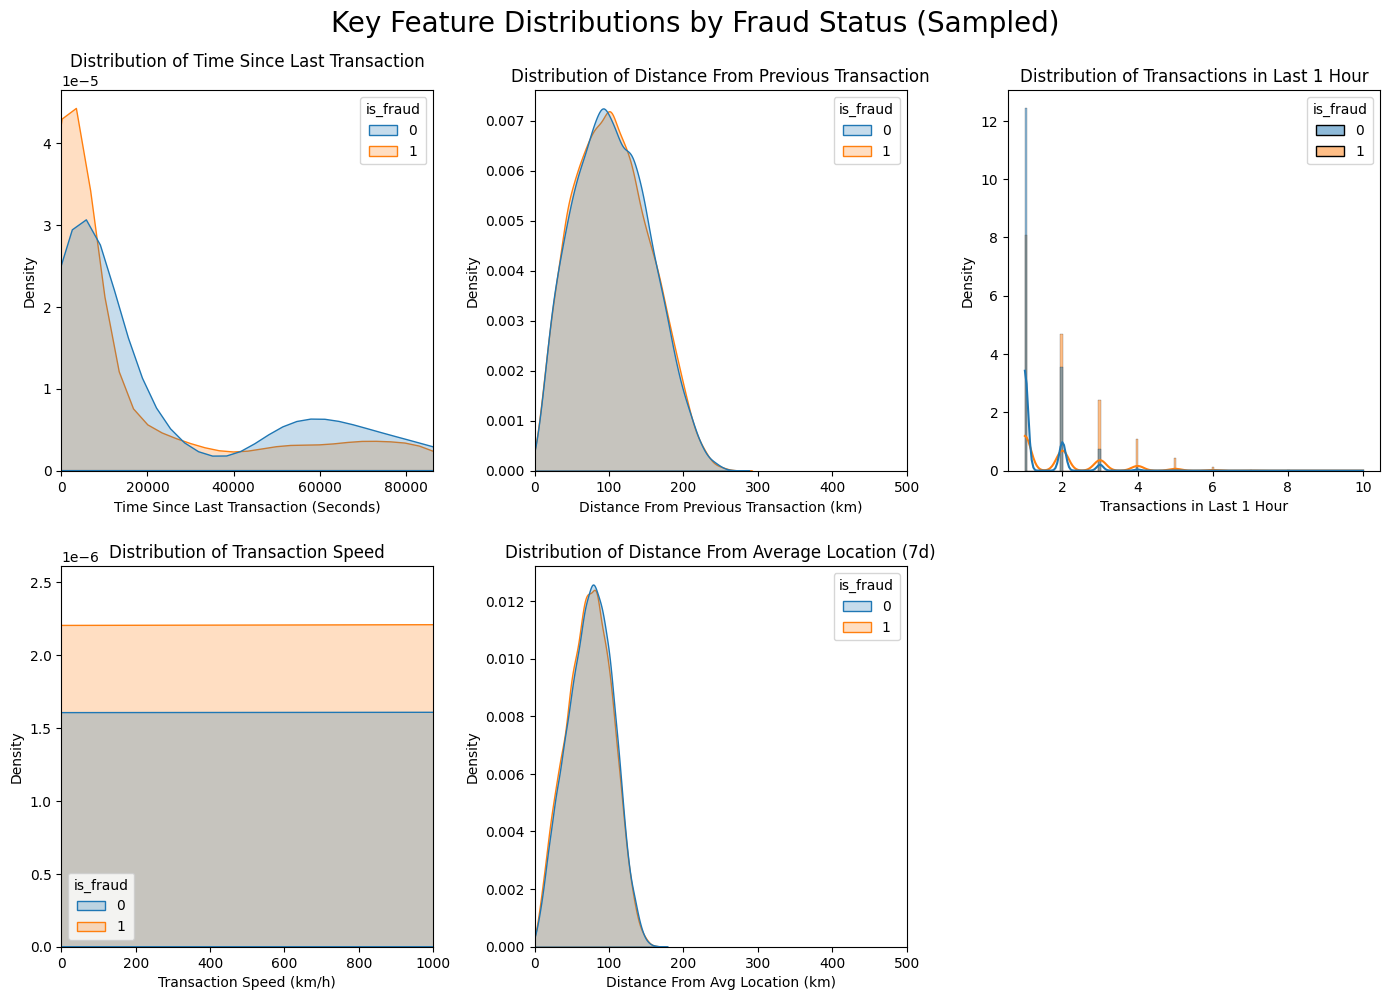

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 14))
axes = axes.flatten() # Flatten the 2x3 array of axes for easier iteration

# --- Plot: Time Since Last Transaction ---
sns.kdeplot(data=plot_df, x='time_since_last_trans_seconds', hue='is_fraud', common_norm=False, fill=True, ax=axes[0])
axes[0].set_title('Distribution of Time Since Last Transaction')
axes[0].set_xlabel('Time Since Last Transaction (Seconds)')
axes[0].set_xlim(0, 3600 * 24) # Limit to 24 hours for better visibility

# --- Plot: Distance From Previous Transaction ---
sns.kdeplot(data=plot_df, x='distance_from_prev', hue='is_fraud', common_norm=False, fill=True, ax=axes[1])
axes[1].set_title('Distribution of Distance From Previous Transaction')
axes[1].set_xlabel('Distance From Previous Transaction (km)')
axes[1].set_xlim(0, 500) # Limit to 500km for better visibility

# --- Plot: Transactions in Last 1 Hour ---
sns.histplot(data=plot_df, x='trans_in_last_1h', hue='is_fraud', kde=True, stat='density', common_norm=False, ax=axes[2])
axes[2].set_title('Distribution of Transactions in Last 1 Hour')
axes[2].set_xlabel('Transactions in Last 1 Hour')

# --- NEW Plot: Transaction Speed (km/h) ---
sns.kdeplot(data=plot_df, x='trans_speed_kmh', hue='is_fraud', common_norm=False, fill=True, ax=axes[3])
axes[3].set_title('Distribution of Transaction Speed')
axes[3].set_xlabel('Transaction Speed (km/h)')
axes[3].set_xlim(0, 1000) # Cap at 1000 km/h for visibility, as outliers can be extreme

# --- NEW Plot: Distance From Average Location ---
sns.kdeplot(data=plot_df, x='distance_from_avg_location_7d', hue='is_fraud', common_norm=False, fill=True, ax=axes[4])
axes[4].set_title('Distribution of Distance From Average Location (7d)')
axes[4].set_xlabel('Distance From Avg Location (km)')
axes[4].set_xlim(0, 500) # Cap at 500km for visibility

# Hide any unused subplots
for i in range(5, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout() # Adjust subplot params for a tight layout
plt.suptitle('Key Feature Distributions by Fraud Status (Sampled)', y=1.02, fontsize=20)
plt.show()

We can see some of these graphs are a bit weird, and its clear that the data skews towards the left.
The best way to overcome this is to do a log transformation log(1+n)

In [22]:
# --- Apply log1p transformation to highly skewed continuous features ---
plot_df['log_time_since_last_trans_seconds'] = np.log1p(plot_df['time_since_last_trans_seconds'])
plot_df['log_distance_from_prev'] = np.log1p(plot_df['distance_from_prev'])
plot_df['log_trans_speed_kmh'] = np.log1p(plot_df['trans_speed_kmh'])
plot_df['log_distance_from_avg_location_7d'] = np.log1p(plot_df['distance_from_avg_location_7d'])

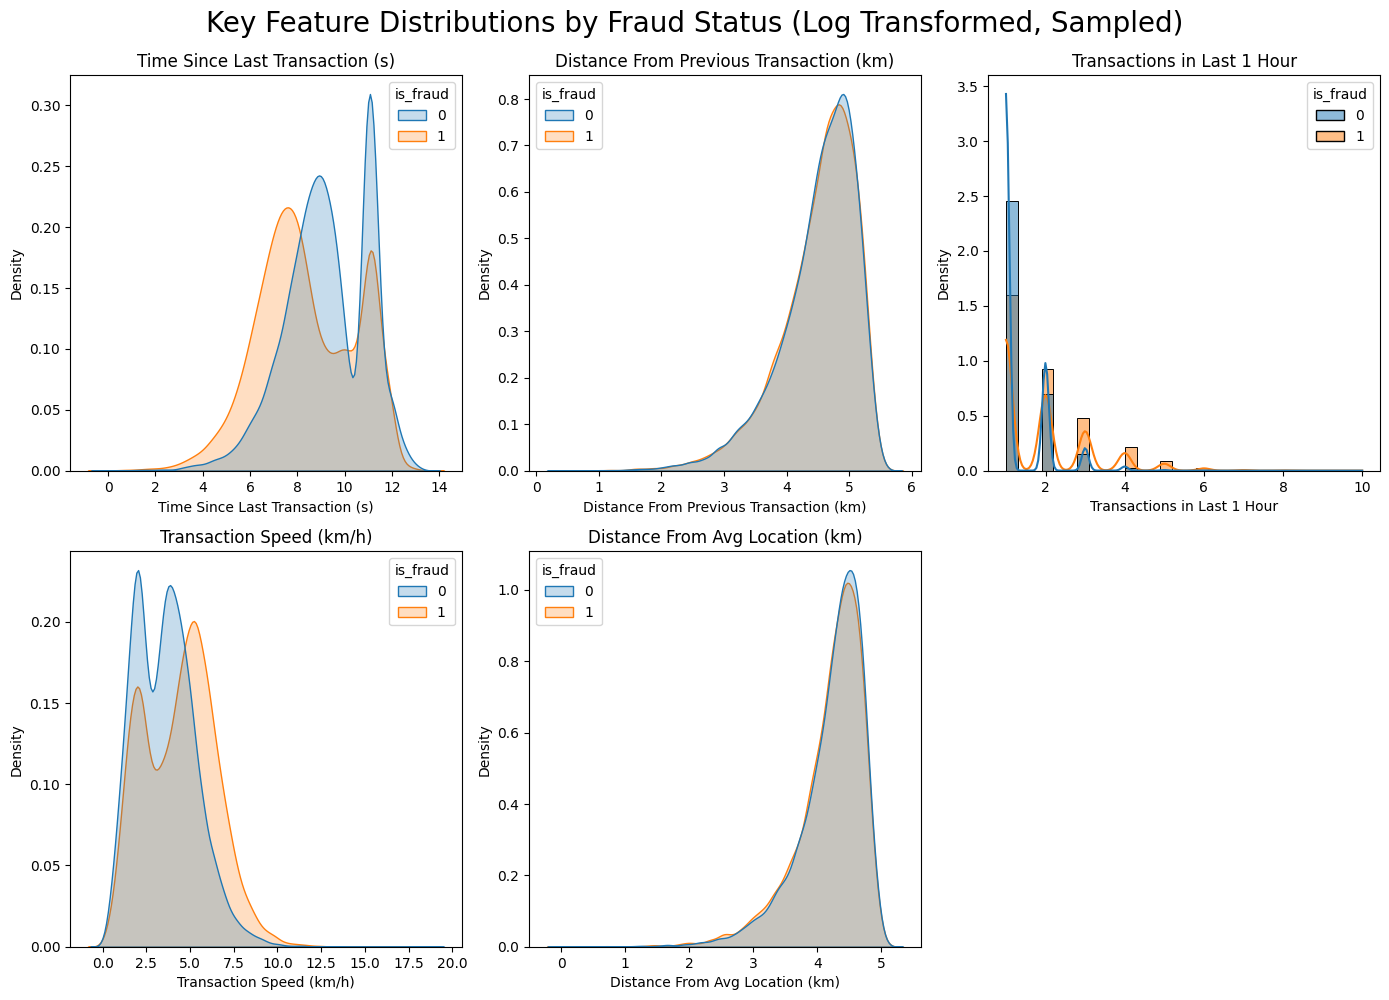

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 14))
axes = axes.flatten() # Flatten the 2x3 array of axes for easier iteration

# List of features to plot and their titles
plot_features = [
    ('log_time_since_last_trans_seconds', 'Time Since Last Transaction (s)'),
    ('log_distance_from_prev', 'Distance From Previous Transaction (km)'),
    ('trans_in_last_1h', 'Transactions in Last 1 Hour'),
    ('log_trans_speed_kmh', 'Transaction Speed (km/h)'),
    ('log_distance_from_avg_location_7d', 'Distance From Avg Location (km)')
]

for i, (feature_col, title) in enumerate(plot_features):
    ax = axes[i]
    if feature_col == 'trans_in_last_1h':
        # Use histplot for counts
        sns.histplot(data=plot_df, x=feature_col, hue='is_fraud', kde=True, stat='density', common_norm=False, ax=ax, bins=30)
    else:
        # Use kdeplot for log-transformed continuous features
        sns.kdeplot(data=plot_df, x=feature_col, hue='is_fraud', common_norm=False, fill=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(title)
    ax.set_ylabel('Density')

# Hide any unused subplots (if you have an odd number of plots in an even grid)
if len(plot_features) < len(axes):
    for j in range(len(plot_features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout() # Adjust subplot params for a tight layout
plt.suptitle('Key Feature Distributions by Fraud Status (Log Transformed, Sampled)', y=1.02, fontsize=20)
plt.show()

## Observations

### 1. Time Since Last Transaction

What it shows: The time elapsed since the previous transaction for a given card, log-transformed, separated by fraud status.

**Key Observations**: fraud transactions have a pronounced peak towards the lower end of the log-transformed time scale (roughly between 6 and 8 on the X-axis).
The blue curve (legitimate) has its main peak shifted significantly to the higher end (around 11 on the X-axis), indicating longer times between transactions.

There's also a smaller, secondary peak for legitimate transactions overlapping with the fraud peak, indicating some legitimate rapid transactions.

Interpretation in Context of Fraud: This is a strong signal!

The fraud peak at lower log-times indicates that fraudulent transactions often occur in rapid succession. We can think of this in two ways:

- **Card testing**: making small, quick purchases to see if a stolen card is active

- **Bust-out attack**: Maxing out a card quickly before it's reported

Legitimate users, on the other hand, typically have more natural, longer pauses between their purchases throughout the day or week.


### 2. Distance from previous transaction

**What it shows**: The geographical distance from the previous transaction location, log-transformed, by fraud status.

**Key Observations**: Both the orange (fraud) and blue (legitimate) curves are largely overlapping and peak around the same log-transformed distance (around 4.5-5 on the X-axis).
There's no clear visual separation between the two distributions.

Interpretation in Context of Fraud: This feature, by itself, seems to be a weaker differentiator after log transformation.

It suggests that many fraudulent transactions, even after transformation, don't necessarily occur at a drastically different distance from the previous one compared to legitimate transactions.

There is a possibility the log transformation compressed the extreme outliers too much to see a subtle signal. But I have a hunch the merchants from our data might not be as spread as I initially thought.

Implications for the Model: While not a strong standalone feature here, it might still contribute in combination with other features (e.g., in transaction_speed_kmh) or if the model can pick up on small, subtle differences that aren't obvious visually.

### 3. Distribution of Transactions in Last 1 Hour by Fraud Status

What it shows: The count of transactions within the last hour for a given card, by fraud status.

Key Observations:
The blue curve (legitimate) is peaks sharply at 1 transaction, with rapidly diminishing density for higher counts. Legitimate users rarely make more than a couple of transactions in an hour.
The orange curve (fraud) also has a peak at 1, but critically, it shows a fatter tail and higher densities at counts like 2, 3, 4, and 5+ transactions in an hour.

Interpretation in Context of Fraud: This is another good signal!
The higher density for fraud at elevated transaction counts confirms the "burstiness" pattern. Fraudsters often make multiple small attempts or purchases in a short timeframe.

Implications for the Model: This feature will help identify cards that suddenly show an unusually high volume of activity in a short period, which is highly indicative of fraud.

### 4. Transaction Speed (km/h)

What it shows: The calculated speed between consecutive transactions, log-transformed, by fraud status.

Key Observations:
The blue curve (legitimate) has its main peak at lower log-transformed speeds (around 2-3 on the X-axis), indicating normal, physically possible travel speeds between transactions.

The orange curve (fraud) has a distinct and significant peak shifted towards much higher log-transformed speeds (around 6-8 on the X-axis). This indicates speeds that are often physically impossible.
There's some overlap where legitimate and fraudulent transactions occur at similar, lower speeds.

Interpretation in Context of Fraud: This is a very strong feature!
The fraud peak at high log-speeds directly flags "teleportation" – transactions occurring too far apart in too short a time for any human to travel. This is a classic fraud indicator.

Implications for the Model: This is likely one of your most powerful features. The model will heavily weight transactions with high `transaction_speed_kmh` as fraudulent.

### 5. Distance From Avg Location (km)

What it shows: The distance of the current transaction from the card's 7-day rolling average location, log-transformed, by fraud status.

**Key Observations**: Similar `Distance From Previous (km)`, the distributions for fraud and legitimate transactions are largely overlapping.
Both curves peak around the same log-transformed distance (around 4.5 on the X-axis).

Interpretation in Context of Fraud: This feature, after log transformation, also appears to be a weaker standalone differentiator.

It suggests that simply being "far from the average" isn't as distinct a fraud signal as the speed or rapid succession. This could be due to legitimate travel leading to high distances, or many fraudulent transactions still occurring relatively close to a user's recent (7-day) activity.

Implications for the Model: Like `distance_from_prev`, this might not be a primary driver but could contribute in concert with other features. It's possible that the raw, extreme outliers for this feature (before log transform) were more indicative, or that its signal is more nuanced.


Spolier: I have tried to train a model using these features, and unsurprisingly, it didn't do well. Based on the above, data, the model might as well be creating predictions based on 3 features instead of 5.
But before I proceed, I have a hunch that location and location based features aren't going to be as helpful as I thought.  I confirm if merchant locations are as spread out as I initialy thought.

In [24]:
from scipy.spatial.distance import cdist

# Distance Statistics
print("\n3. DISTANCE STATISTICS (excluding NaN)")
print("-" * 60)
distance_stats = feature_df.groupby('is_fraud')['distance_from_prev'].describe()
print(distance_stats)

print("\n4. TRANSACTION SPEED STATISTICS (excluding NaN)")
print("-" * 60)
speed_stats = feature_df.groupby('is_fraud')['trans_speed_kmh'].describe()
print(speed_stats)

# Merchant Clustering Analysis
print("\n5. MERCHANT CLUSTERING (Unique Merchant Locations)")
print("-" * 60)

# Get unique merchant locations
unique_merchants = feature_df[['merchant', 'merch_lat', 'merch_long', 'is_fraud']].drop_duplicates('merchant')

# Calculate pairwise distances between all unique merchants
merchant_coords = unique_merchants[['merch_lat', 'merch_long']].values
pairwise_distances = cdist(merchant_coords, merchant_coords, metric='euclidean')

# Convert to km (rough approximation: 1 degree ≈ 111 km)
pairwise_distances_km = pairwise_distances * 111

# Get upper triangle (exclude diagonal and duplicates)
upper_triangle_indices = np.triu_indices_from(pairwise_distances_km, k=1)
distances_between_merchants = pairwise_distances_km[upper_triangle_indices]

print(f"Total unique merchants: {len(unique_merchants)}")
print(f"Mean distance between merchants: {distances_between_merchants.mean():.2f} km")
print(f"Median distance between merchants: {np.median(distances_between_merchants):.2f} km")
print(f"Min distance between merchants: {distances_between_merchants.min():.2f} km")
print(f"Max distance between merchants: {distances_between_merchants.max():.2f} km")


3. DISTANCE STATISTICS (excluding NaN)
------------------------------------------------------------
              count        mean        std       min        25%         50%  \
is_fraud                                                                      
0         4452798.0  104.208385  50.584908  0.046363  64.854800  101.511482   
1           18800.0  103.953859  50.175365  0.814649  65.001102  101.419773   

                 75%         max  
is_fraud                          
0         140.508121  289.681689  
1         139.746018  271.321202  

4. TRANSACTION SPEED STATISTICS (excluding NaN)
------------------------------------------------------------
              count          mean           std       min        25%  \
is_fraud                                                               
0         4452798.0  10355.675514  1.136776e+06  0.003141   7.386152   
1           18800.0  14422.839143  1.067133e+06  0.020357  12.283610   

                50%         75%           m

/tmp/ipython-input-4212910738.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


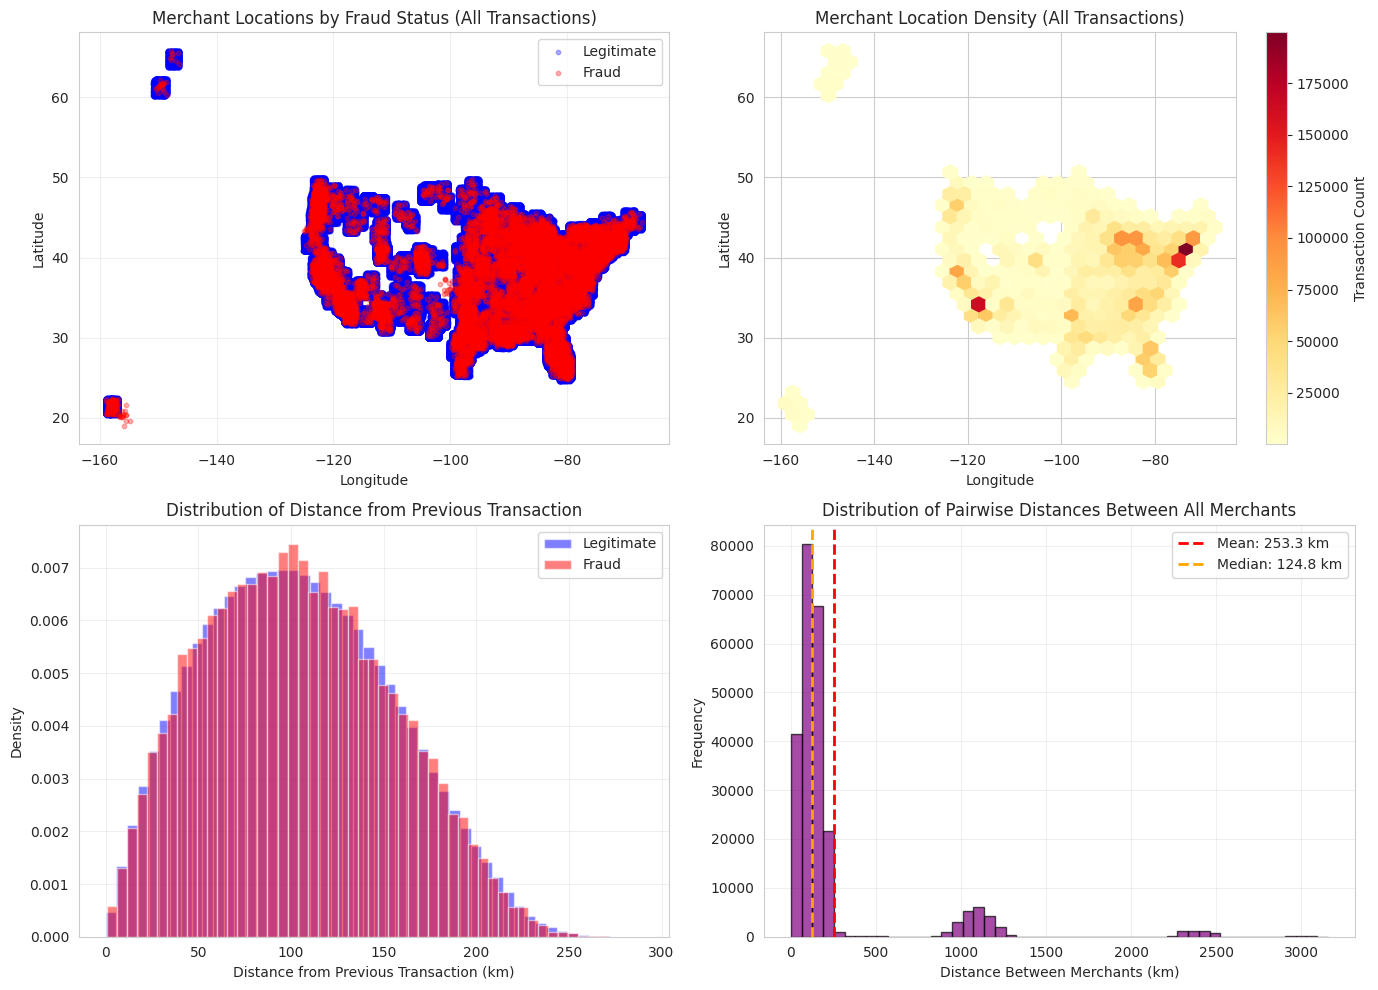

In [25]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter plot of all merchant locations
ax1 = axes[0, 0]
for fraud_status, color, label in [(0, 'blue', 'Legitimate'), (1, 'red', 'Fraud')]:
    subset = feature_df[feature_df['is_fraud'] == fraud_status]
    ax1.scatter(subset['merch_long'], subset['merch_lat'],
                alpha=0.3, s=10, c=color, label=label)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Merchant Locations by Fraud Status (All Transactions)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Hexbin density plot
ax2 = axes[0, 1]
hexbin = ax2.hexbin(feature_df['merch_long'], feature_df['merch_lat'],
                     gridsize=30, cmap='YlOrRd', mincnt=1)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Merchant Location Density (All Transactions)')
plt.colorbar(hexbin, ax=ax2, label='Transaction Count')

# Distance from previous transaction distribution
ax3 = axes[1, 0]
for fraud_status, color, label in [(0, 'blue', 'Legitimate'), (1, 'red', 'Fraud')]:
    subset = feature_df[(feature_df['is_fraud'] == fraud_status) & (feature_df['distance_from_prev'].notna())]
    ax3.hist(subset['distance_from_prev'], bins=50, alpha=0.5,
             color=color, label=label, density=True)
ax3.set_xlabel('Distance from Previous Transaction (km)')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of Distance from Previous Transaction')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Pairwise merchant distance distribution
ax4 = axes[1, 1]
ax4.hist(distances_between_merchants, bins=50, color='purple', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Distance Between Merchants (km)')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Pairwise Distances Between All Merchants')
ax4.axvline(distances_between_merchants.mean(), color='red',
            linestyle='--', linewidth=2, label=f'Mean: {distances_between_merchants.mean():.1f} km')
ax4.axvline(np.median(distances_between_merchants), color='orange',
            linestyle='--', linewidth=2, label=f'Median: {np.median(distances_between_merchants):.1f} km')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This confirms my previous hunch. The merchants aren't as spread out as I hoped.

## Next steps
We'll work with what works instead. I'll start by remove all our features related to location and engineer more features based on the transaction time.

# Feature engineering - Round 2

This time we'll remove all location features and data and try and work with amount and time data.

Lets go back to our `feature_df` and remove all the unnecessary columns

In [26]:
feat_columns_to_drop = ["distance_from_prev", "distance_from_avg_location_7d"]

feature_df = feature_df.drop(columns=feat_columns_to_drop)

 Let's plot fraud transactions based on the hour of day, as I feel like I might have overlooked this

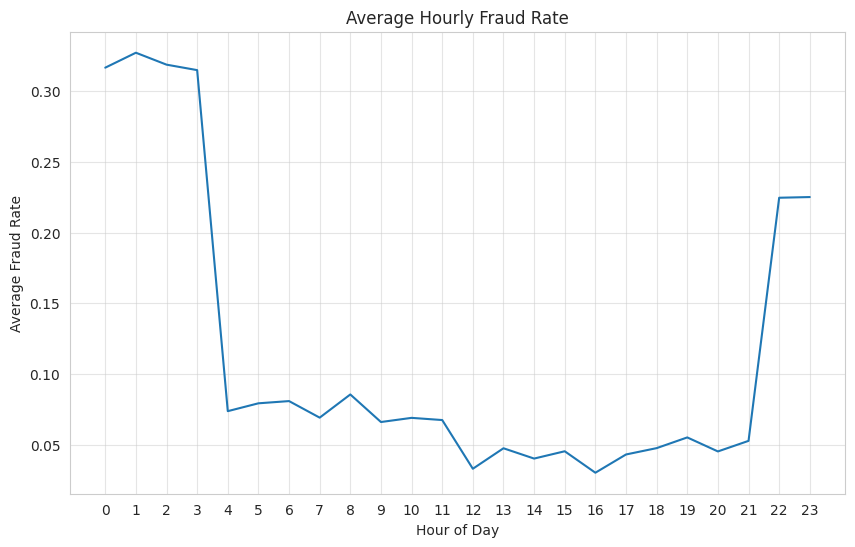

In [27]:
# Aggregate fraud rate by hour of the day
df_hourly_fraud = feature_df.set_index('trans_datetime').groupby(pd.Grouper(freq='h'))['is_fraud'].mean().reset_index()
df_hourly_fraud['hour_of_day'] = df_hourly_fraud['trans_datetime'].dt.hour

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_hourly_fraud.groupby('hour_of_day')['is_fraud'].mean().reset_index(), x='hour_of_day', y='is_fraud')
plt.title('Average Hourly Fraud Rate')
plt.xlabel('Hour of Day')
plt.ylabel('Average Fraud Rate')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.5)
plt.show()

Some strong signals here! A lot of fraud transaction occur between 0 and 4 and then 21 and 23. But what about day of week?

In [28]:
# Extract 'hour_of_day' as a base feature
feature_df['hour_of_day'] = feature_df['trans_datetime'].dt.hour

# is_late_night_fraud_window: Hours 0, 1, 2, 3
feature_df['is_late_night_fraud_window'] = feature_df['hour_of_day'].isin([0, 1, 2, 3]).astype(int)

# is_late_evening_fraud_window: Hours 22, 23
feature_df['is_late_evening_fraud_window'] = feature_df['hour_of_day'].isin([22, 23]).astype(int)

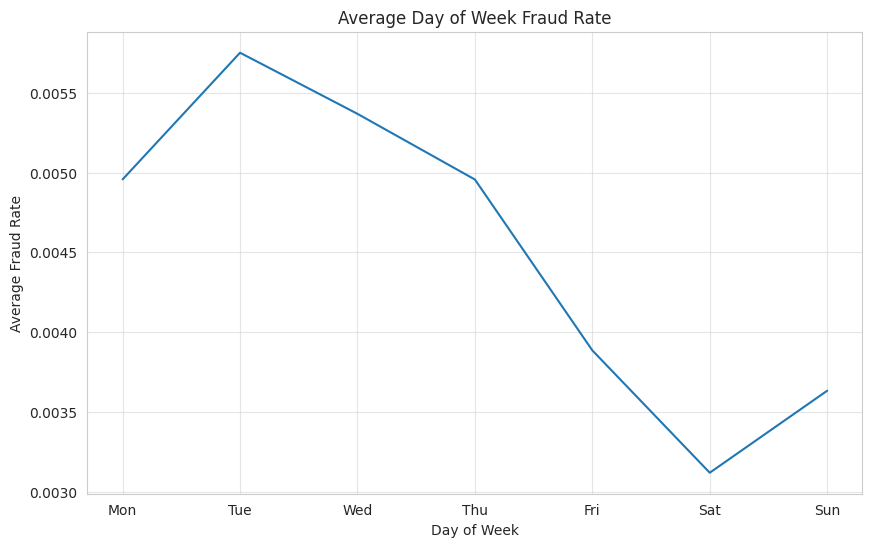

In [29]:
# Aggregate fraud rate by hour of the day
feature_df['day_of_week'] = feature_df['trans_datetime'].dt.weekday

# This directly groups by day_of_week and calculates the mean fraud rate for each day.
df_dow_fraud_rate = feature_df.groupby('day_of_week')['is_fraud'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_dow_fraud_rate, x='day_of_week', y='is_fraud')

plt.title('Average Day of Week Fraud Rate')
plt.xlabel('Day of Week') # Corrected label
plt.ylabel('Average Fraud Rate')

# Corrected xticks and added labels for readability
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True, alpha=0.5)
plt.show()

In [30]:
time_windows = ['1h', '24h', '7d']
epsilon = 1e-6

for window in time_windows:
    feature_df[f'amt_per_card_avg_ratio_{window}'] = np.nan

# Group by 'cc_num' and apply the rolling calculation within each group
# This avoids creating one giant rolling object for the entire DataFrame
def calculate_rolling_card_ratio(group):
    group = group.sort_values('trans_datetime') # Ensure sorted within group
    for window in time_windows:
        rolling_avg = group.rolling(window=window, on='trans_datetime', closed='left')['amt'].mean()
        # Calculate the ratio. Add a small epsilon to the denominator to prevent division by zero.
        group[f'amt_per_card_avg_ratio_{window}'] = group['amt'] / (rolling_avg.fillna(0) + epsilon)
    return group

# Apply the function to each card group
# Using `apply` with `groupby` is generally more memory-efficient than `merge` for this pattern.
feature_df = feature_df.groupby('cc_num', group_keys=False).apply(calculate_rolling_card_ratio)

/tmp/ipython-input-3718165838.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_df = feature_df.groupby('cc_num', group_keys=False).apply(calculate_rolling_card_ratio)


In [31]:
for window in time_windows:
    feature_df[f'amt_per_category_avg_ratio_{window}'] = np.nan

def calculate_rolling_category_ratio(group):
    group = group.sort_values('trans_datetime')
    for window in time_windows:
        rolling_avg = group.rolling(window=window, on='trans_datetime', closed='left')['amt'].mean()
        group[f'amt_per_category_avg_ratio_{window}'] = group['amt'] / (rolling_avg.fillna(0) + epsilon)
    return group

feature_df = feature_df.groupby(['cc_num', 'category'], group_keys=False).apply(calculate_rolling_category_ratio)

/tmp/ipython-input-959427.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_df = feature_df.groupby(['cc_num', 'category'], group_keys=False).apply(calculate_rolling_category_ratio)


In [32]:
median_windows = ['1d', '7d']
for window in median_windows:
    feature_df[f'amt_diff_from_card_median_{window}'] = np.nan

def calculate_rolling_card_median_diff(group):
    group = group.sort_values('trans_datetime')
    for window in median_windows:
        rolling_median = group.rolling(window=window, on='trans_datetime', closed='left')['amt'].median()
        group[f'amt_diff_from_card_median_{window}'] = group['amt'] - rolling_median.fillna(0)
    return group

feature_df = feature_df.groupby('cc_num', group_keys=False).apply(calculate_rolling_card_median_diff)

/tmp/ipython-input-2893927181.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_df = feature_df.groupby('cc_num', group_keys=False).apply(calculate_rolling_card_median_diff)


In [33]:
# --- Final Cleanup ---
# Fill any remaining NaNs in the newly created features (e.g., for initial transactions
# where no prior window data existed). A 0.0 fill is common for differences.
# For ratios, 1.0 (meaning current amount is "average") or 0.0 (no prior context) can be considered.
# For simplicity, let's fill with 0.0 for all new ratio/diff features.
new_feature_cols = [col for col in feature_df.columns if any(s in col for s in ['ratio', 'diff'])]
feature_df[new_feature_cols] = feature_df[new_feature_cols].fillna(0.0)

display(feature_df.head(10))

,trans_datetime,cc_num,acct_num,trans_num,category,amt,is_fraud,merchant,merch_lat,merch_long,...,is_late_evening_fraud_window,day_of_week,amt_per_card_avg_ratio_1h,amt_per_card_avg_ratio_24h,amt_per_card_avg_ratio_7d,amt_per_category_avg_ratio_1h,amt_per_category_avg_ratio_24h,amt_per_category_avg_ratio_7d,amt_diff_from_card_median_1d,amt_diff_from_card_median_7d
0,2023-01-01 02:15:59,60400268763,279317935556,417473688cec715a2d4fc745a3267cc5,gas_transport,2.35,0,fraud_Mraz-Herzog,40.699828,-93.120762,...,0,6,2.350000e+06,2.350000e+06,2.350000e+06,2.350000e+06,2.350000e+06,2.350000e+06,2.350,2.350
1,2023-01-01 02:24:55,60400268763,279317935556,79472dbb9cf569a748a0f7006a48f8c0,gas_transport,8.04,0,"fraud_Eichmann, Bogan and Rodriguez",41.968246,-92.851952,...,0,6,3.421275e+00,3.421275e+00,3.421275e+00,3.421275e+00,3.421275e+00,3.421275e+00,5.690,5.690
2,2023-01-01 03:41:06,60400268763,279317935556,1367c01d358ac62facf92c1193bfd65a,gas_transport,71.50,0,fraud_Cummings LLC,40.577116,-93.014709,...,0,6,7.150000e+07,1.376323e+01,1.376323e+01,7.150000e+07,1.376323e+01,1.376323e+01,66.305,66.305
3,2023-01-01 04:22:17,60400268763,279317935556,4a050f70a34d8d9e8f018e718cc55a76,gas_transport,8.86,0,"fraud_Schaefer, McGlynn and Bosco",42.462321,-92.647985,...,0,6,1.239161e-01,3.245817e-01,3.245817e-01,1.239161e-01,3.245817e-01,3.245817e-01,0.820,0.820
4,2023-01-01 07:26:18,60400268763,279317935556,8e6e3632682c8ba66bfd8bced49003c4,gas_transport,116.26,0,fraud_Harris Inc,41.155424,-94.097921,...,0,6,1.162600e+08,5.124407e+00,5.124407e+00,1.162600e+08,5.124407e+00,5.124407e+00,107.810,107.810
5,2023-01-01 09:15:20,60400268763,279317935556,acf7a73dd6e9bc14f95d1142392ffdfa,gas_transport,2.97,0,"fraud_Stroman, Hudson and Erdman",40.555592,-93.981711,...,0,6,2.970000e+06,7.173566e-02,7.173566e-02,2.970000e+06,7.173566e-02,7.173566e-02,-5.890,-5.890
6,2023-01-01 09:19:31,60400268763,279317935556,429c92b1479ed3a67ae1412ee3dca295,gas_transport,78.36,0,fraud_Harris Inc,42.348254,-93.781877,...,0,6,2.638383e+01,2.239070e+00,2.239070e+00,2.638383e+01,2.239070e+00,2.239070e+00,69.910,69.910
7,2023-01-01 09:54:41,60400268763,279317935556,ea0c7419d6b4476a99f4996646800ebb,gas_transport,9.49,0,"fraud_Eichmann, Bogan and Rodriguez",42.432608,-93.579400,...,0,6,2.333702e-01,2.303877e-01,2.303877e-01,2.333702e-01,2.303877e-01,2.303877e-01,0.630,0.630
8,2023-01-01 11:08:40,60400268763,279317935556,848b7fa4673193192b24cd81a48f54cb,gas_transport,26.36,0,fraud_Torp-Labadie,41.977031,-94.541152,...,0,6,2.636000e+07,7.080549e-01,7.080549e-01,2.636000e+07,7.080549e-01,7.080549e-01,17.185,17.185
9,2023-01-02 03:17:51,60400268763,279317935556,2c39928294c4825c30ee9d281d1614f2,gas_transport,83.26,0,"fraud_Lind, Huel and McClure",42.053091,-94.261269,...,0,0,8.326000e+07,1.857298e+00,2.311422e+00,8.326000e+07,1.857298e+00,2.311422e+00,56.900,73.770


In [34]:
feature_df.columns

Index(['trans_datetime', 'cc_num', 'acct_num', 'trans_num', 'category', 'amt',
       'is_fraud', 'merchant', 'merch_lat', 'merch_long',
       'time_since_last_trans_seconds', 'trans_speed_kmh', 'trans_in_last_1h',
       'trans_in_last_24h', 'trans_in_last_7d', 'hour_of_day',
       'is_late_night_fraud_window', 'is_late_evening_fraud_window',
       'day_of_week', 'amt_per_card_avg_ratio_1h',
       'amt_per_card_avg_ratio_24h', 'amt_per_card_avg_ratio_7d',
       'amt_per_category_avg_ratio_1h', 'amt_per_category_avg_ratio_24h',
       'amt_per_category_avg_ratio_7d', 'amt_diff_from_card_median_1d',
       'amt_diff_from_card_median_7d'],
      dtype='object')

In [35]:
import pandas as pd
import numpy as np

# Assuming 'feature_df' is your DataFrame and has all the necessary columns
# Make sure to run the memory-efficient feature engineering code first to populate these columns

# Get all fraud cases
fraud_df = feature_df[feature_df['is_fraud'] == 1].copy()

# Sample an equal number of legitimate cases (or slightly more, e.g., 5x)
# Ensure the sample size doesn't exceed available legitimate transactions
n_legit_sample = min(len(fraud_df) * 1, len(feature_df[feature_df['is_fraud'] == 0])) # 1:1 ratio for now, can be adjusted
legit_sample = feature_df[feature_df['is_fraud'] == 0].sample(n=n_legit_sample, random_state=42).copy()
# Combine for plotting
plot_df = pd.concat([fraud_df, legit_sample])

# It's good practice to handle NaNs for plotting, especially for new features
# For rolling features, NaNs typically appear at the beginning of a card's transaction history.
# Filling with 0.0 is a reasonable strategy for these, as it means 'no activity' or 'no difference' prior.
# We'll fillna for the original columns before creating log-transformed versions.
features_to_check_for_nan = [
    'trans_in_last_1h',
    'trans_in_last_24h',
    'trans_in_last_7d',
    'amt_per_card_avg_ratio_1h',
    'amt_per_card_avg_ratio_24h',
    'amt_per_card_avg_ratio_7d',
    'amt_per_category_avg_ratio_1h',
    'amt_per_category_avg_ratio_24h',
    'amt_per_category_avg_ratio_7d',
    'amt_diff_from_card_median_1d',
    'amt_diff_from_card_median_7d'
]
for col in features_to_check_for_nan:
    if col in plot_df.columns:
        plot_df[col] = plot_df[col].fillna(0.0) # Fill NaNs for the original features


# --- Apply log1p transformation ONLY to highly skewed, non-negative continuous features ---
# These are typically counts or ratios.
continuous_skewed_features = [
    'trans_in_last_1h',
    'trans_in_last_24h',
    'trans_in_last_7d',
    'amt_per_card_avg_ratio_1h',
    'amt_per_card_avg_ratio_24h',
    'amt_per_card_avg_ratio_7d',
    'amt_per_category_avg_ratio_1h',
    'amt_per_category_avg_ratio_24h',
    'amt_per_category_avg_ratio_7d'
]

for feature in continuous_skewed_features:
    if feature in plot_df.columns:
        # Ensure values are non-negative before log1p, as a safeguard
        # (though our feature engineering should ensure this for ratios/counts)
        plot_df[f'log_{feature}'] = np.log1p(plot_df[feature].clip(lower=0))

# --- Features NOT to log-transform (discrete/binary/can be negative) ---
# 'hour_of_day', 'day_of_week', 'is_late_night_fraud_window', 'is_late_evening_fraud_window'
# These are better kept as is or treated as categorical if not used as ordinal.
# For 'amt_diff_from_card_median_X', plot the original values,
# or consider a 'signed log' transformation if you absolutely need to transform it for modeling later.
# For plotting distributions of features that can be negative, standard plots (histograms, KDEs)
# work well on the raw values.

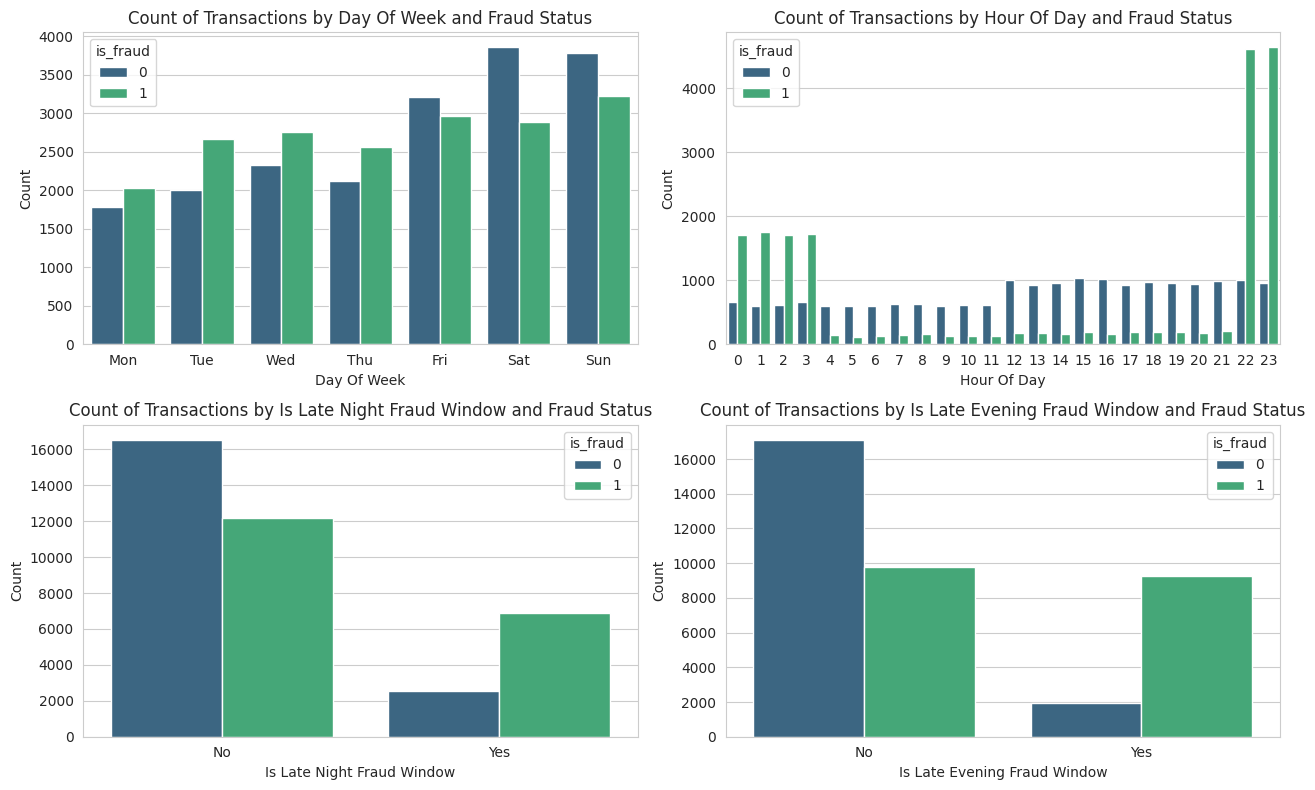

In [36]:
# --- Plotting Discrete Features with Countplots ---

# Set up the plotting style
sns.set_style("whitegrid")

# Define features to plot based on their type
discrete_features = [
    'day_of_week',
    'hour_of_day',
    'is_late_night_fraud_window',
    'is_late_evening_fraud_window'
]

# --- Plotting Discrete Features with Countplots ---
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 2 * len(discrete_features)))
axes = axes.flatten()

for i, feature in enumerate(discrete_features):
    sns.countplot(data=plot_df, x=feature, hue='is_fraud', ax=axes[i], palette='viridis')
    axes[i].set_title(f'Count of Transactions by {feature.replace("_", " ").title()} and Fraud Status')
    axes[i].set_xlabel(feature.replace("_", " ").title())
    axes[i].set_ylabel('Count')
    # Customise xticks for readability if needed (e.g., for day_of_week)
    if feature == 'day_of_week':
        axes[i].set_xticks(range(7))
        axes[i].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    elif feature == 'is_late_night_fraud_window' or feature == 'is_late_evening_fraud_window':
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

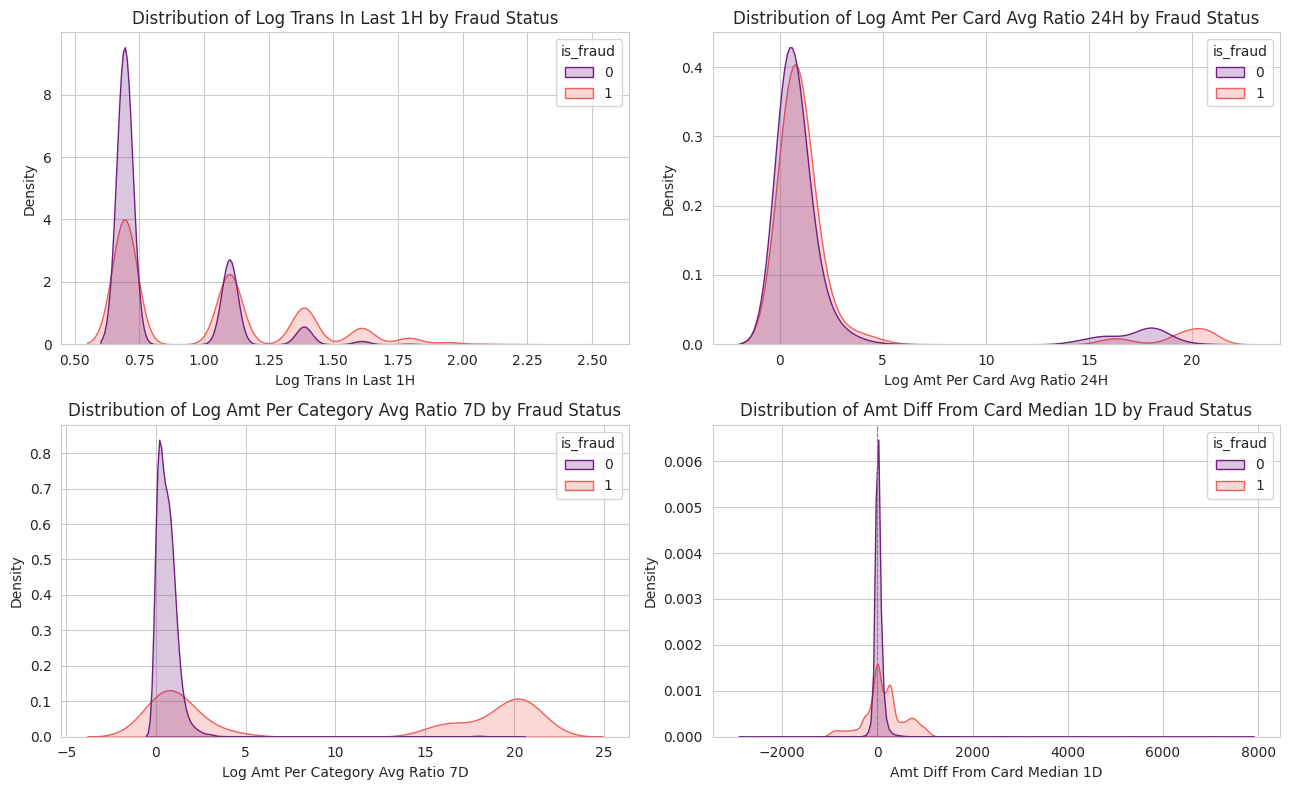

In [37]:
# --- Plotting Continuous Features with KDE Plots ---
# Combine log-transformed and raw continuous features for plotting

log_transformed_continuous_features = [
    'log_trans_in_last_1h',
    'log_amt_per_card_avg_ratio_24h',
    'log_amt_per_category_avg_ratio_7d'
]

raw_continuous_features = [
    'amt_diff_from_card_median_1d'
]

all_continuous_features_for_kde = log_transformed_continuous_features + raw_continuous_features

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 2 * len(all_continuous_features_for_kde)))
axes = axes.flatten()

for i, feature in enumerate(all_continuous_features_for_kde):
    sns.kdeplot(data=plot_df, x=feature, hue='is_fraud', common_norm=False, fill=True, ax=axes[i], palette='magma')
    axes[i].set_title(f'Distribution of {feature.replace("_", " ").title()} by Fraud Status')
    axes[i].set_xlabel(feature.replace("_", " ").title())
    axes[i].set_ylabel('Density')
    # Add a vertical line at 0 for difference features if they can be negative
    if 'diff' in feature:
        axes[i].axvline(0, color='grey', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

In [38]:
features_to_log = [
    'trans_in_last_1h',
    'trans_in_last_24h',
    'trans_in_last_7d',
    'amt_per_card_avg_ratio_1h',
    'amt_per_card_avg_ratio_24h',
    'amt_per_card_avg_ratio_7d',
    'amt_per_category_avg_ratio_1h',
    'amt_per_category_avg_ratio_24h',
    'amt_per_category_avg_ratio_7d'
]

transformed_df = feature_df.copy()

for feature in features_to_log:
    # Fill NaNs with 0 before log1p transformation for consistency if they are not meant to be missing
    # Or, handle them specifically later. For demo data, filling with 0 is a simple approach
    # if NaN implies 'no previous transaction' or 'no distance'.
    transformed_df[f'log_{feature}'] = np.log1p(feature_df[feature].fillna(0))

In [39]:
display(transformed_df.head(5))

,trans_datetime,cc_num,acct_num,trans_num,category,amt,is_fraud,merchant,merch_lat,merch_long,...,amt_diff_from_card_median_7d,log_trans_in_last_1h,log_trans_in_last_24h,log_trans_in_last_7d,log_amt_per_card_avg_ratio_1h,log_amt_per_card_avg_ratio_24h,log_amt_per_card_avg_ratio_7d,log_amt_per_category_avg_ratio_1h,log_amt_per_category_avg_ratio_24h,log_amt_per_category_avg_ratio_7d
0,2023-01-01 02:15:59,60400268763,279317935556,417473688cec715a2d4fc745a3267cc5,gas_transport,2.35,0,fraud_Mraz-Herzog,40.699828,-93.120762,...,2.350,0.693147,0.693147,0.693147,14.669926,14.669926,14.669926,14.669926,14.669926,14.669926
1,2023-01-01 02:24:55,60400268763,279317935556,79472dbb9cf569a748a0f7006a48f8c0,gas_transport,8.04,0,"fraud_Eichmann, Bogan and Rodriguez",41.968246,-92.851952,...,5.690,1.098612,1.098612,1.098612,1.486428,1.486428,1.486428,1.486428,1.486428,1.486428
2,2023-01-01 03:41:06,60400268763,279317935556,1367c01d358ac62facf92c1193bfd65a,gas_transport,71.50,0,fraud_Cummings LLC,40.577116,-93.014709,...,66.305,0.693147,1.386294,1.386294,18.085208,2.692140,2.692140,18.085208,2.692140,2.692140
3,2023-01-01 04:22:17,60400268763,279317935556,4a050f70a34d8d9e8f018e718cc55a76,gas_transport,8.86,0,"fraud_Schaefer, McGlynn and Bosco",42.462321,-92.647985,...,0.820,1.098612,1.609438,1.609438,0.116819,0.281097,0.281097,0.116819,0.281097,0.281097
4,2023-01-01 07:26:18,60400268763,279317935556,8e6e3632682c8ba66bfd8bced49003c4,gas_transport,116.26,0,fraud_Harris Inc,41.155424,-94.097921,...,107.810,0.693147,1.791759,1.791759,18.571340,1.812282,1.812282,18.571340,1.812282,1.812282


# Data seperation for frontend testing

In [41]:
transformed_df[['log_amt_per_card_avg_ratio_1h', 'log_trans_in_last_1h', 'amt_diff_from_card_median_7d']].describe()

,log_amt_per_card_avg_ratio_1h,log_trans_in_last_1h,amt_diff_from_card_median_7d
count,4.473591e+06,4.473591e+06,4.473591e+06
mean,1.284761e+01,8.210713e-01,2.575704e+01
std,7.320501e+00,2.238026e-01,1.651600e+02
min,1.080623e-04,6.931472e-01,-1.101765e+04
25%,2.793679e+00,6.931472e-01,-2.165500e+01
50%,1.655182e+01,6.931472e-01,-1.050000e-01
75%,1.801661e+01,1.098612e+00,3.831500e+01
max,2.455891e+01,2.397895e+00,4.629199e+04


In [42]:
# --- 1. Fraudulent Demo Data ---
# Select a few actual fraudulent transactions (no change needed here)
fraud_demo_data = transformed_df[transformed_df['is_fraud'] == 1].sample(n=5, random_state=42).copy()

# --- 2. Legitimate Demo Data ---
# Select a few clearly legitimate transactions with normal characteristics:
# - log_amt_per_card_avg_ratio_1h around the median (e.g., between 15 and 17)
# - log_trans_in_last_1h indicating low velocity (1 or 2 transactions)
# - amt_diff_from_card_median_7d very close to zero
legitimate_candidates = transformed_df[
    (transformed_df['is_fraud'] == 0) &
    (transformed_df['log_amt_per_card_avg_ratio_1h'] >= 15.0) & # Around the median
    (transformed_df['log_amt_per_card_avg_ratio_1h'] <= 17.0) &
    (transformed_df['log_trans_in_last_1h'] < 1.1) &  # Covers 1-2 transactions (up to 75th percentile)
    (transformed_df['amt_diff_from_card_median_7d'].abs() < 10.0) # Very close to zero deviation
].sample(n=5, random_state=42).copy()
legitimate_demo_data = legitimate_candidates

# --- 3. Mixed Demo Data ---
# Find cc_nums that have both legitimate and fraudulent transactions (no change needed here)
mixed_cc_nums = transformed_df.groupby('cc_num')['is_fraud'].nunique()
mixed_cc_nums = mixed_cc_nums[mixed_cc_nums > 1].index

if not mixed_cc_nums.empty:
    chosen_cc_num_for_mixed = mixed_cc_nums[0]
    mixed_demo_data = transformed_df[transformed_df['cc_num'] == chosen_cc_num_for_mixed].sample(n=5, random_state=42).copy()
else:
    print("Warning: No 'cc_num' found with both legitimate and fraudulent transactions for 'Mixed' demo data.")
    mixed_demo_data = pd.DataFrame(columns=transformed_df.columns)

# --- 4. Suspicious Demo Data ---
# Select legitimate transactions (is_fraud == 0) that show some mild anomalies.
# Look for values that are elevated but not extreme, hinting at potential risk.
suspicious_candidates = transformed_df[
    (transformed_df['is_fraud'] == 0) &
    (
        # Elevated spending spike (above 75th percentile, but not max)
        ((transformed_df['log_amt_per_card_avg_ratio_1h'] > 18.0) &
         (transformed_df['log_amt_per_card_avg_ratio_1h'] < 20.0)) |

        # Moderate transaction velocity (above 75th percentile, but not max)
        ((transformed_df['log_trans_in_last_1h'] > 1.1) &
         (transformed_df['log_trans_in_last_1h'] < 1.8)) |

        # Noticeable amount deviation from median (outside 75th percentile, but not extreme)
        ((transformed_df['amt_diff_from_card_median_7d'].abs() > 40.0) &
         (transformed_df['amt_diff_from_card_median_7d'].abs() < 200.0))
    )
].sample(n=5, random_state=42).copy()
suspicious_demo_data = suspicious_candidates

In [43]:
# Store these DataFrames for your backend
demo_datasets = {
    'fraud': fraud_demo_data,
    'legitimate': legitimate_demo_data,
    'mixed': mixed_demo_data,
    'suspicious': suspicious_demo_data
}

# Training with XGBoost

In [44]:
def prepare_features(df, cols_to_drop):
    """
    Prepares the DataFrame for model training by:
    1. Defining target column.
    2. Handling NaNs in continuous features.
    3. Applying log1p transformation to specified skewed continuous features.
    4. Dropping ID and original (untransformed) continuous features.

    Args:
        df (pd.DataFrame): The input DataFrame after initial feature engineering
        cols_to_drop_ids: List of columns to drop from the final feature matrix.
        cols_to_drop_redundant: List of redundant columns to drop.
                          Features that are continuous, skewed, and should be log1p transformed

    Returns:
        tuple: A tuple containing:
            - X_full (pd.DataFrame): Features ready for model training.
            - y_full (pd.Series): Target variable (is_fraud).
    """

    target_col = "is_fraud"

    # First, handle NaNs in the original continuous features before any transformation
    # Fill with 0.0 as it often implies 'no prior activity/difference' for these types of features.
    for col in continuous_skewed_features + ['amt_diff_from_card_median_1d', 'amt_diff_from_card_median_7d']:
        if col in transformed_df.columns:
            transformed_df[col] = transformed_df[col].fillna(0.0)


    # Apply log1p transformation to specified features, creating new columns
    features_to_drop_after_log = []
    for feature in continuous_skewed_features:
        if feature in df.columns:
            new_log_feature_name = f'log_{feature}'
            # Ensure values are non-negative before log1p
            df[new_log_feature_name] = np.log1p(df[feature].clip(lower=0))
            features_to_drop_after_log.append(feature) # Mark original for dropping

    # Create feature matrix X and target vector y
    X_full = df.drop(columns=cols_to_drop)
    y_full = df[target_col].astype(int)

    print(f"Full dataset prepared with {X_full.shape[1]} features and {len(X_full)} samples.")

    return X_full, y_full

cols_to_drop_ids = ['is_fraud', 'trans_datetime', 'cc_num', 'acct_num',
                    'trans_num', 'merchant', 'category']

cols_to_drop_redundant = features_to_log
cols_to_drop = cols_to_drop_ids + cols_to_drop_redundant

X, y = prepare_features(feature_df.copy(), cols_to_drop)

Full dataset prepared with 20 features and 4473591 samples.


In [46]:
def run_time_series_cv(X_full, y_full, n_splits=5, xgb_params=None):
    """
    Performs TimeSeriesSplit cross-validation with an XGBoost classifier.

    Args:
        X_full (pd.DataFrame): The full feature matrix.
        y_full (pd.Series): The full target vector.
        n_splits (int, optional): Number of splits for TimeSeriesSplit. Defaults to 5.
        xgb_params (dict, optional): Dictionary of XGBoost parameters to override defaults.
                                     Defaults to None, using predefined parameters.

    Returns:
        tuple: A tuple containing:
            - roc_auc_scores (list): List of ROC AUC scores for each fold.
            - auprc_scores (list): List of AUPRC scores for each fold.
            - f1_scores (list): List of F1 scores (at default 0.5 threshold) for each fold.
            - last_fold_y_test (pd.Series): y_test from the last fold.
            - last_fold_y_pred_proba (np.array): Predicted probabilities from the last fold.
            - final_model (xgb.XGBClassifier): Trained model from the last fold.
    """

    tscv = TimeSeriesSplit(n_splits=n_splits)

    roc_auc_scores, auprc_scores, f1_scores = [], [], []
    last_fold_y_test = None
    last_fold_y_pred_proba = None

    # Default XGBoost parameters
    default_xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'n_estimators': 500,
        'learning_rate': 0.05,
        'max_depth': 4,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'tree_method': 'hist' # Use 'gpu_hist' on Colab w/ GPU, or 'hist' for CPU
    }

    # Override defaults with any provided parameters
    if xgb_params:
        default_xgb_params.update(xgb_params)

    for fold, (train_index, test_index) in enumerate(tscv.split(X_full)):
        print(f"\n===== FOLD {fold + 1}/{n_splits} =====")

        X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
        y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

        print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples.")

        # Filling NaNs here (e.g., if any remain or are introduced by feature engineering)
        # Assuming 0 is a reasonable fill for numerical features, adjust if needed.
        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)

        # Calculate scale_pos_weight for class imbalance
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum() if (y_train == 1).sum() > 0 else 1
        default_xgb_params['scale_pos_weight'] = scale_pos_weight

        model = xgb.XGBClassifier(**default_xgb_params)

        model.fit(X_train, y_train, verbose=False)

        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred_class = model.predict(X_test) # Default 0.5 threshold prediction

        if len(np.unique(y_test)) < 2:
            print(f"WARNING: Only one class present in y_test for Fold {fold + 1}. Skipping metrics.")
            roc_auc_scores.append(np.nan)
            auprc_scores.append(np.nan)
            f1_scores.append(np.nan)
        else:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            auprc = average_precision_score(y_test, y_pred_proba)
            f1 = f1_score(y_test, y_pred_class) # F1 at default 0.5 threshold

            roc_auc_scores.append(roc_auc)
            auprc_scores.append(auprc)
            f1_scores.append(f1)

            print(f"Fold {fold + 1} -> ROC AUC: {roc_auc:.4f}, AUPRC: {auprc:.4f}, F1 Score (default 0.5): {f1:.4f}")

        # Store results from the last fold for external plotting/analysis
        if fold == n_splits - 1:
            last_fold_y_test = y_test
            last_fold_y_pred_proba = y_pred_proba
            final_model = model

    return roc_auc_scores, auprc_scores, f1_scores, last_fold_y_test, last_fold_y_pred_proba, final_model

roc_auc, auprc, f1, y_true_last, y_proba_last, trained_model = run_time_series_cv(X, y, n_splits=5)


===== FOLD 1/5 =====
Training on 745601 samples, Testing on 745598 samples.
Fold 1 -> ROC AUC: 0.9994, AUPRC: 0.9639, F1 Score (default 0.5): 0.7428

===== FOLD 2/5 =====
Training on 1491199 samples, Testing on 745598 samples.
Fold 2 -> ROC AUC: 0.9996, AUPRC: 0.9691, F1 Score (default 0.5): 0.6831

===== FOLD 3/5 =====
Training on 2236797 samples, Testing on 745598 samples.
Fold 3 -> ROC AUC: 0.9995, AUPRC: 0.9713, F1 Score (default 0.5): 0.6430

===== FOLD 4/5 =====
Training on 2982395 samples, Testing on 745598 samples.
Fold 4 -> ROC AUC: 0.9998, AUPRC: 0.9753, F1 Score (default 0.5): 0.6356

===== FOLD 5/5 =====
Training on 3727993 samples, Testing on 745598 samples.
Fold 5 -> ROC AUC: 0.9998, AUPRC: 0.9741, F1 Score (default 0.5): 0.6445


In [47]:
print("\n" + "="*60)
print("AVERAGE PERFORMANCE ACROSS ALL FOLDS")
print("="*60)
print(f"Average ROC AUC: {np.nanmean(roc_auc):.4f} (+/- {np.nanstd(roc_auc):.4f})")
print(f"Average AUPRC:   {np.nanmean(auprc):.4f} (+/- {np.nanstd(auprc):.4f})")
print(f"Average F1 Score (default 0.5):  {np.nanmean(f1):.4f} (+/- {np.nanstd(f1):.4f})")


AVERAGE PERFORMANCE ACROSS ALL FOLDS
Average ROC AUC: 0.9996 (+/- 0.0002)
Average AUPRC:   0.9707 (+/- 0.0040)
Average F1 Score (default 0.5):  0.6698 (+/- 0.0401)


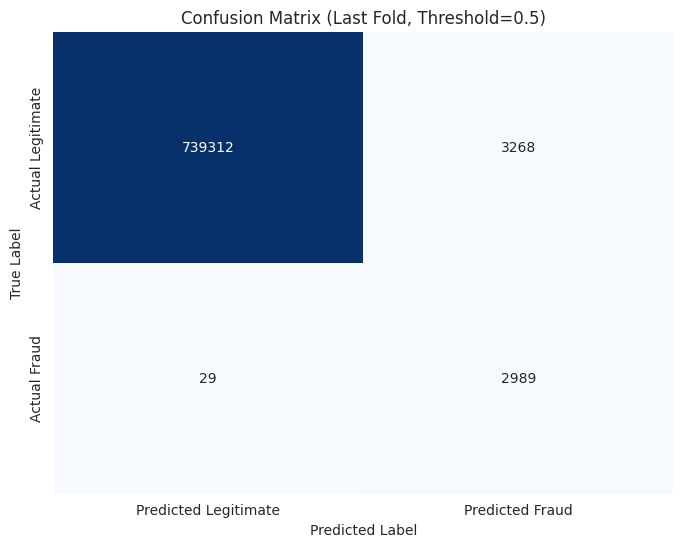

In [48]:

last_fold_y_test = y_true_last
last_fold_y_pred_proba = y_proba_last

if last_fold_y_test is not None and last_fold_y_pred_proba is not None:
    # Convert probabilities to binary predictions using a default threshold (0.5)
    # This is the threshold you would tune to optimise F1, Recall, or Precision
    default_threshold = 0.5
    last_fold_y_pred_class = (last_fold_y_pred_proba >= default_threshold).astype(int)

    cm = confusion_matrix(last_fold_y_test, last_fold_y_pred_class)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Legitimate', 'Predicted Fraud'],
                yticklabels=['Actual Legitimate', 'Actual Fraud'])
    plt.title(f'Confusion Matrix (Last Fold, Threshold={default_threshold})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # For a slightly different display using ConfusionMatrixDisplay (more sklearn native)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate', 'Fraud'])
    # disp.plot(cmap='Blues', values_format='d')
    # plt.title(f'Confusion Matrix (Last Fold, Threshold={default_threshold})')
    # plt.show()

else:
    print("Last fold's test data or predictions not available. Please run the cross-validation first.")

## Threshold tuning

Optimal Threshold (max F1): 0.9824
Max F1 Score: 0.9263
Precision at optimal threshold: 0.9474
Recall at optimal threshold: 0.9062


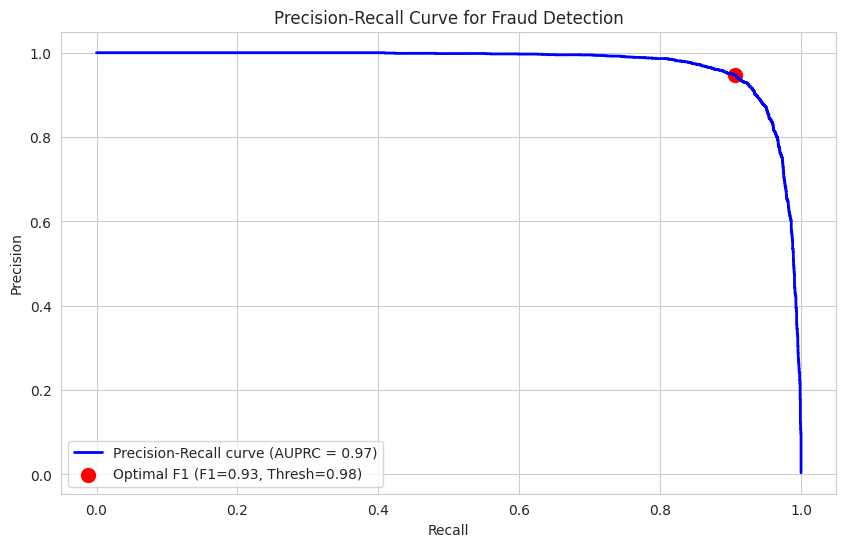


Classification Report at Optimal Threshold (0.9824):
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00    742580
       Fraud       0.95      0.91      0.93      3018

    accuracy                           1.00    745598
   macro avg       0.97      0.95      0.96    745598
weighted avg       1.00      1.00      1.00    745598


Confusion Matrix at Optimal Threshold:
[[742428    152]
 [   283   2735]]


In [49]:
if last_fold_y_test is not None and last_fold_y_pred_proba is not None:
    # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(last_fold_y_test, last_fold_y_pred_proba)

    # Calculate F1 score for each threshold
    f1_scores_at_thresholds = (2 * precision * recall) / (precision + recall)
    f1_scores_at_thresholds[np.isnan(f1_scores_at_thresholds)] = 0 # Handle division by zero

    # Find the threshold that maximises F1 Score
    optimal_f1_idx = np.argmax(f1_scores_at_thresholds)
    optimal_threshold = thresholds[optimal_f1_idx]
    max_f1_score = f1_scores_at_thresholds[optimal_f1_idx]
    optimal_precision = precision[optimal_f1_idx]
    optimal_recall = recall[optimal_f1_idx]

    print(f"Optimal Threshold (max F1): {optimal_threshold:.4f}")
    print(f"Max F1 Score: {max_f1_score:.4f}")
    print(f"Precision at optimal threshold: {optimal_precision:.4f}")
    print(f"Recall at optimal threshold: {optimal_recall:.4f}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUPRC = {average_precision_score(last_fold_y_test, last_fold_y_pred_proba):.2f})')
    plt.scatter(optimal_recall, optimal_precision, marker='o', color='red', s=100,
                label=f'Optimal F1 (F1={max_f1_score:.2f}, Thresh={optimal_threshold:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Fraud Detection')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    # Optional: Display classification report at the optimal threshold
    print(f"\nClassification Report at Optimal Threshold ({optimal_threshold:.4f}):")
    y_pred_optimal_threshold = (last_fold_y_pred_proba >= optimal_threshold).astype(int)
    print(classification_report(last_fold_y_test, y_pred_optimal_threshold, target_names=['Legitimate', 'Fraud']))
    print("\nConfusion Matrix at Optimal Threshold:")
    print(confusion_matrix(last_fold_y_test, y_pred_optimal_threshold))

else:
    print("Not enough data from the last fold to perform threshold tuning and plotting.")

=== Metrics at Optimal Threshold (0.9824) ===
Precision: 0.9470
Recall: 0.9062
F1 Score: 0.9262



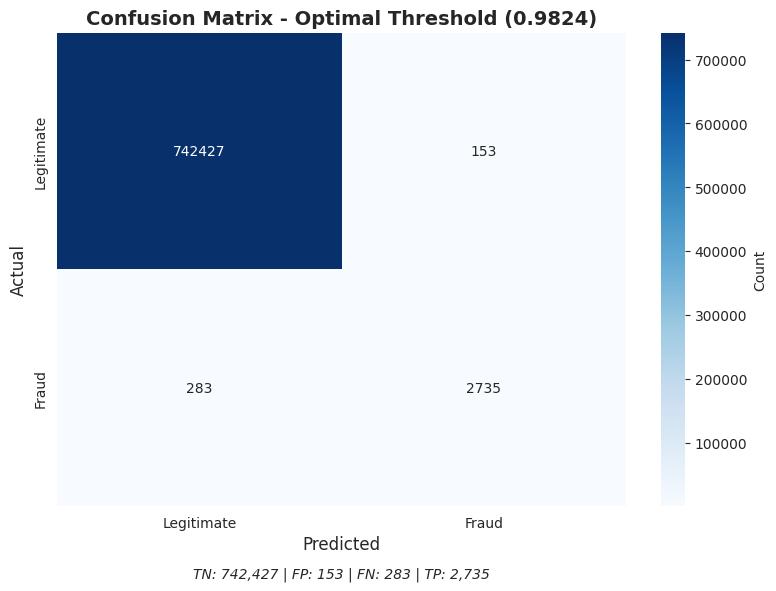


=== Classification Report ===
              precision    recall  f1-score   support

  Legitimate     0.9996    0.9998    0.9997    742580
       Fraud     0.9470    0.9062    0.9262      3018

    accuracy                         0.9994    745598
   macro avg     0.9733    0.9530    0.9629    745598
weighted avg     0.9994    0.9994    0.9994    745598


=== Comparison: Default (0.5) vs Optimal (0.9824) ===
Metric          Default (0.5)   Optimal         Change         
------------------------------------------------------------
Precision       0.4777          0.9470          +0.4693
Recall          0.9904          0.9062          -0.0842
F1 Score        0.6445          0.9262          +0.2816

=== False Positive Analysis (Your 'Frenzy' Metric) ===
Legitimate transactions in test set: 742,580
FP at default threshold (0.5): 3,268 (0.44% of legitimate)
FP at optimal threshold (0.9824): 153 (0.02% of legitimate)
FP reduction: 3,115 fewer false alarms (95.3% reduction)


In [50]:
# Apply optimal threshold from above
optimal_threshold = 0.9824
y_pred_optimal = (y_proba_last >= optimal_threshold).astype(int)

# Calculate metrics at optimal threshold
precision_opt = precision_score(last_fold_y_test, y_pred_optimal)
recall_opt = recall_score(last_fold_y_test, y_pred_optimal)
f1_opt = f1_score(last_fold_y_test, y_pred_optimal)

print(f"=== Metrics at Optimal Threshold ({optimal_threshold}) ===")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"F1 Score: {f1_opt:.4f}\n")

# Generate confusion matrix
cm = confusion_matrix(last_fold_y_test, y_pred_optimal)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'],
            cbar_kws={'label': 'Count'})

plt.title(f'Confusion Matrix - Optimal Threshold ({optimal_threshold})', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)

# Add text annotations for clarity
tn, fp, fn, tp = cm.ravel()
plt.text(0.5, -0.15, f'TN: {tn:,} | FP: {fp:,} | FN: {fn:,} | TP: {tp:,}',
         ha='center', transform=ax.transAxes, fontsize=10, style='italic')

plt.tight_layout()
plt.show()

# Detailed classification report
print("\n=== Classification Report ===")
print(classification_report(last_fold_y_test, y_pred_optimal,
                          target_names=['Legitimate', 'Fraud'],
                          digits=4))

# Compare with default threshold (0.5)
y_pred_default = (y_proba_last >= 0.5).astype(int)
f1_default = f1_score(last_fold_y_test, y_pred_default)
precision_default = precision_score(last_fold_y_test, y_pred_default)
recall_default = recall_score(last_fold_y_test, y_pred_default)

print(f"\n=== Comparison: Default (0.5) vs Optimal ({optimal_threshold}) ===")
print(f"{'Metric':<15} {'Default (0.5)':<15} {'Optimal':<15} {'Change':<15}")
print(f"{'-'*60}")
print(f"{'Precision':<15} {precision_default:<15.4f} {precision_opt:<15.4f} {precision_opt - precision_default:+.4f}")
print(f"{'Recall':<15} {recall_default:<15.4f} {recall_opt:<15.4f} {recall_opt - recall_default:+.4f}")
print(f"{'F1 Score':<15} {f1_default:<15.4f} {f1_opt:<15.4f} {f1_opt - f1_default:+.4f}")

# FP analysis (your key concern)
fp_default = confusion_matrix(last_fold_y_test, y_pred_default)[0, 1]
fp_optimal = fp
legitimate_count = (last_fold_y_test == 0).sum()

print(f"\n=== False Positive Analysis (Your 'Frenzy' Metric) ===")
print(f"Legitimate transactions in test set: {legitimate_count:,}")
print(f"FP at default threshold (0.5): {fp_default:,} ({fp_default/legitimate_count*100:.2f}% of legitimate)")
print(f"FP at optimal threshold ({optimal_threshold}): {fp_optimal:,} ({fp_optimal/legitimate_count*100:.2f}% of legitimate)")
print(f"FP reduction: {fp_default - fp_optimal:,} fewer false alarms ({(1 - fp_optimal/fp_default)*100:.1f}% reduction)")

# Save the trained XGboost model

The trained model from the last fold of the cross-validation is stored in the `model` variable within the `run_time_series_cv` function, which was the last model fitted. I need to import `joblib` and save this model instance.


In [56]:
import joblib

save_path = "/content/drive/MyDrive/Fraud Detection project files/fraud-detection/backend/model_data/"

# Save model
joblib.dump(trained_model, f'{save_path}/fraud_model.pkl')

# Also save feature names (critical for SHAP and production)
joblib.dump(X.columns.tolist(), f'{save_path}/feature_names.pkl')

# Save optimal threshold
joblib.dump(optimal_threshold, f'{save_path}/optimal_threshold.pkl')

# Save demo datasets
joblib.dump(demo_datasets, f'{save_path}/demo_datasets.pkl')

print("Model saved: fraud_model.pkl")
print("Features saved: feature_names.pkl")
print("Threshold saved: optimal_threshold.pkl")
print("Demo datasets saved: demo_datasets.pkl")

Model saved: fraud_model.pkl
Features saved: feature_names.pkl
Threshold saved: optimal_threshold.pkl
Demo datasets saved: demo_datasets.pkl
